In [1]:
import numpy as np
import pandas as pd
import os

# plotting 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# data manager and analysis
import vodex as vx
import numan as nu

# writing files
import tifffile as tif

%load_ext autoreload
%autoreload 2

# Project structure: 

Provide the project folder with the "processed" folder created in the previous notebook. 

As you keep going with the analysis, the folder will have the following structure: 

```
processed
│   experiment.json <----------------------------------- (DONE in 01) the file that contains everything about the experiment, you are creating it once and will be reusing ever after
│   experiment_dff.json <------------------------------- (DONE in 01) everything about the experiment, but loads from the dff movie, not from the raw data
└───dff_movie  <---------------------------------------- (DONE in 01) the dff movie :) 
│   │   dff_movie_0000.tif
│   │   dff_movie_0001.tif
│   │   ... 
└───tscore_volumes  <----------------------------------- (WILL BE DONE in this notebook) t-score tif files per pair
│   └───2v3
│       │   tscore_2v3.tif
│   └───3v5
│       │   tscore_3v5.tif
│   └───2v5
│       │   tscore_2v5.tif
│   └───2vB
│       │   tscore_2vB.tif
│   └───3vB
│       │   tscore_3vB.tif
│   └───5vB
│       │   tscore_5vB.tif
│   └───BvB1
│       │   tscore_BvB1.tif
│   └───BvB2
│       │   tscore_BvB2.tif
│   └───BvB3
│       │   tscore_BvB3.tif
└───diff_volumes  <------------------------------------- (WILL BE DONE in this notebook) absolute difference tif files per pair
│   └───2v3
│       │   diff_2v3.tif
│   └───3v5
│       │   diff_3v5.tif
│   └───...
└───spots
│   └───imaris  <--------------------------------------- ATTENTION : You need to put stuff generated by imaris into this folder!!! 
│       │   └───tscore_2v3_Statistics
│       │       │     tscore_2v3_Position.csv
│       │       │     tscore_2v3_Diameter.csv
│       │       │     ...
│       │   └───tscore_3v5_Statistics
│       │       │     tscore_3v5_Position.csv
│       │       │     tscore_3v5_Diameter.csv
│       │       │     ...
│       │   └───tscore_2v5_Statistics
│       │       │     ...
│       │   └───...
│   └───signals  <-------------------------------------- json files with the extracted signals, also will have the group info after you added it
│       │   spots_2v3.json
│       │   spots_3v5.json
│       │   spots_2v5.json
│       │     ...
│   └───reports  <---------------------------------- tiffs and pdf with the cells significant in any pairwise comparison
│       └───all_significant  <---------------------- tiffs and pdf with all significant cells per group
│           │   └───signals  <---------------------- pdfs with signals
│           │       │     ...
│           │   └───images <------------------------ tif masks 
│           │       │     ...
│       └───groupped  <----------------------------- tiffs and pdf where the cells are groupped based on signal shape .. or anything else you want
│           │   readme.txt  <----------------------- ATTENTION : you need to describe the groups
│           │   └───signals  <---------------------- pdfs with signals
│           │       │     ...
│           │   └───images  <----------------------- tif masks 
│           │       │     ...
```
# Set project folder
Also, if the processed folder should already exist if you created dff movies. If the folder doesn't exist, it will complain ...

In [2]:
project_folder = "E:/Peter/numan/notebooks/data/2vs3vs5/"
path = os.path.join(project_folder, 'processed')

assert os.path.isdir(path), "the directory 'processed' doesn't exist in the project," \
                                " did you forget to run the previous notebook?"

Set the processed directory as our working directory:

In [3]:
os.chdir(path)
os.getcwd()

'E:\\Peter\\numan\\notebooks\\data\\2vs3vs5\\processed'

# Load experiment with the dff_movie as the data: 

In [4]:
experiment = vx.from_json(vx.Experiment, "experiment_dff.json")
experiment.summary()

Total of 67 files.
Check the order :
[ 0 ] dff_movie_0000.tif : 936 frames
[ 1 ] dff_movie_0001.tif : 572 frames
[ 2 ] dff_movie_0002.tif : 572 frames
[ 3 ] dff_movie_0003.tif : 572 frames
[ 4 ] dff_movie_0004.tif : 572 frames
[ 5 ] dff_movie_0005.tif : 572 frames
[ 6 ] dff_movie_0006.tif : 572 frames
[ 7 ] dff_movie_0007.tif : 572 frames
[ 8 ] dff_movie_0008.tif : 572 frames
[ 9 ] dff_movie_0009.tif : 572 frames
[ 10 ] dff_movie_0010.tif : 572 frames
[ 11 ] dff_movie_0011.tif : 572 frames
[ 12 ] dff_movie_0012.tif : 572 frames
[ 13 ] dff_movie_0013.tif : 572 frames
[ 14 ] dff_movie_0014.tif : 572 frames
[ 15 ] dff_movie_0015.tif : 572 frames
[ 16 ] dff_movie_0016.tif : 572 frames
[ 17 ] dff_movie_0017.tif : 572 frames
[ 18 ] dff_movie_0018.tif : 572 frames
[ 19 ] dff_movie_0019.tif : 572 frames
[ 20 ] dff_movie_0020.tif : 572 frames
[ 21 ] dff_movie_0021.tif : 572 frames
[ 22 ] dff_movie_0022.tif : 572 frames
[ 23 ] dff_movie_0023.tif : 572 frames
[ 24 ] dff_movie_0024.tif : 572 frame

# Create T-Score Image

## get the volumes corresponding to different conditions

In [5]:
def merge_idx(idx_list):
    return np.sort(np.concatenate(idx_list))

blank = vx.Condition(vx.Stimulus('blank','blank'), name = 'blank')
smalldot = vx.Condition(vx.Stimulus('smalldot','smalldot'), name = 'smalldot')
bigdot = vx.Condition(vx.Stimulus('bigdot','bigdot'), name = 'bigdot')

# indeces of the volumes to load
smalldot_idx = experiment.select_volumes(smalldot)
bigdot_idx = experiment.select_volumes(bigdot)

# as blank, we will take the volumes right before the signals 
blank_idx = merge_idx([(smalldot_idx-1), (bigdot_idx-1)])

print(f"We found:\n", 
      f"{smalldot_idx.shape} volumes with smalldot")
print(f" {bigdot_idx.shape} volumes with bigdot")
print(f" {blank_idx.shape} volumes with blank")

We found:
 (190,) volumes with smalldot
 (185,) volumes with bigdot
 (375,) volumes with blank


If you can't fit all the volumes at once, do by pair, or even in chunks ( not implemented yet, but will be ) 

In [6]:
# load the volumes 
smalldot_volumes = experiment.volume_manager.load_volumes(smalldot_idx, verbose = False)
bigdot_volumes = experiment.volume_manager.load_volumes(bigdot_idx, verbose = False)
blank_volumes = experiment.volume_manager.load_volumes(blank_idx, verbose = False)
T,Z,Y,X = bigdot_volumes.shape
print( f"Volumes shape:\nZ : {Z}\nY : {Y}\nX : {X}")

100%|██████████| 19500/19500 [01:09<00:00, 278.89it/s]


Volumes shape:
Z : 52
Y : 684
X : 400


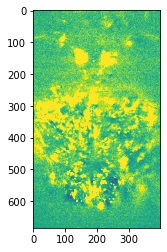

In [7]:
# check a random slice of a volume, make sure it looks as expected ... 
plt.imshow(bigdot_volumes[5,25,:,:],vmin = -100,vmax = 100)

You should see a slice of fish in the image abowe... 

## calculate and write t-score and diff images 
Create the folders to put images in: 

In [9]:
os.makedirs('tscore_volumes')
os.makedirs('diff_volumes')

get a wrapper functins : 



In [10]:
# multiply difference image and t-score image by this constants before turning into integer and writing... 
T_SCALE = 1000
DIFF_SCALE = 100

SHAPE = (Z,Y,X)
RESOLUTION = [4.8, 1.17, 1.17]

def write_image(img, filename):
    tif.imwrite(filename,
                img.astype(np.uint16),shape=SHAPE,
                metadata={'spacing': RESOLUTION[0], 'unit': 'um','axes': 'ZYX'},
                resolution=(1/RESOLUTION[1], 1/RESOLUTION[2]),
                imagej=True)

def make_tscore(volumes1, volumes2, group_tag):
    """
    Creates and writes to dist a tscore image, based on the volumes pair provided. 
    """
    os.makedirs(f"tscore_volumes/{tag}")
    t_img = nu.get_t_score(volumes1, volumes2, absolute = True)*T_SCALE
    write_image(t_img, f'tscore_volumes/{group_tag}/tscore_{group_tag}.tif')
    print(f'max t-image value : {t_img.max()}')
    return t_img
    
def make_diff(volumes1, volumes2, group_tag):
    """
    Creates and writes to dist a tscore image, based on the volumes pair provided. 
    """
    os.makedirs(f"diff_volumes/{tag}")
    diff = nu.get_diff(volumes1, volumes2, absolute = True)*DIFF_SCALE
    write_image(diff, f'diff_volumes/{group_tag}/diff_{group_tag}.tif')
    print(f'diff image : {diff.max()}')
    return diff

### 1. Write tscore and diff images for stimuli and stmuli vs blanks:

In [12]:
t_img = {}
diff_img = {}

tag = "smallvbig"
print(f'{tag}_________________________________')
vol1 = smalldot_volumes
vol2 = bigdot_volumes
t_img[tag] = make_tscore(vol1, vol2, tag)
diff_img[tag] = make_diff(vol1, vol2, tag)

tag = "smallvB"
print(f'{tag}_________________________________')
vol1 = smalldot_volumes
vol2 = blank_volumes
t_img[tag] = make_tscore(vol1, vol2, tag)
diff_img[tag] = make_diff(vol1, vol2, tag)

tag = "bigvB"
print(f'{tag}_________________________________')
vol1 = blank_volumes
vol2 = bigdot_volumes
t_img[tag] = make_tscore(vol1, vol2, tag)
diff_img[tag] = make_diff(vol1, vol2, tag)


smallvbig_________________________________


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'tscore_volumes/smallvbig'

Create maximum and sum T-score and Defference images: highlight the largest changes through all different pairwis comparisons. 

In [ ]:
t_max = np.maximum.reduce([t_img[tag] for tag in ["smallvbig","smallvB","bigvB"]])
write_image(t_max, f'tscore_volumes/tscore_max.tif')

t_sum = np.add.reduce([t_img[tag] for tag in ["smallvbig","smallvB","bigvB"]])
write_image(t_sum, f'tscore_volumes/tscore_sum.tif')

diff_max = np.maximum.reduce([diff_img[tag] for tag in ["smallvbig","smallvB","bigvB"]])
write_image(diff_max, f'diff_volumes/diff_max.tif')

diff_sum = np.add.reduce([diff_img[tag] for tag in ["smallvbig","smallvB","bigvB"]])
write_image(diff_sum, f'diff_volumes/diff_sum.tif')

### 4. t-score images and diff images for random shuffle of blanks 

In [ ]:
np.random.seed(42)

n_blanks = blank_volumes.shape[0]
n_stim = bigdot_volumes.shape[0]

#assert n_stim*2 < n_blanks, "there should be more blank volumes, something went wrong ..."

split_idx = {}
for isplit in [1,2,3]:
    
    tag = f"BvB{isplit}"
    print(f'{tag}_________________________________')
    
    random_set = np.random.choice(n_blanks, size=n_stim*2, replace=False)
    split_idx[f'split{isplit} group1'] = random_set[0:n_stim]
    split_idx[f'split{isplit} group2'] = random_set[n_stim:n_stim*2]
    
    vol1 = blank_volumes[split_idx[f'split{isplit} group1'],:,:,:]
    vol2 = blank_volumes[split_idx[f'split{isplit} group2'],:,:,:]
    
    make_tscore(vol1, vol2, tag)
    make_diff(vol1, vol2, tag)

split_df = pd.DataFrame.from_dict(split_idx)
split_df.to_csv('tscore_volumes/BvB_split_info.csv',index=False)
split_df.to_csv('diff_volumes/BvB_split_info.csv',index=False)    

BvB1_________________________________
max t-image value : 1583.8460731585315
diff image : 36996.875
BvB2_________________________________
max t-image value : 1432.8470396640987
diff image : 35096.875
BvB3_________________________________
max t-image value : 1552.948144011068
diff image : 32715.625


# Now segment the t-score images and add to the project!

You can use any way to segemnt them, we found that using Imaris works really well! 
If you use Imaris, **put hte files that it prodices into processed/spots/imaris**, see the schematics below, We will only need position and diameter, but you can dump all of them there ...


```
processed
│   
└───spots
│   └───imaris  <--------------------------------------- ATTENTION : You need to put stuff generated by imaris into this folder!!! 
│       │   └───tscore_2v3_Statistics
│       │       │     tscore_2v3_Position.csv
│       │       │     tscore_2v3_Diameter.csv
│       │       │     ...
│       │   └───tscore_3v5_Statistics
│       │       │     tscore_3v5_Position.csv
│       │       │     tscore_3v5_Diameter.csv
│       │       │     ...
│       │   └───tscore_2v5_Statistics
│       │       │     ...
│       │   └───...
└───...  
```
The following cell will cerate the folder to put the files into : 

In [ ]:
path = os.path.join(path, 'spots', 'imaris')
os.makedirs(path)